## Some imports

In [12]:
import numpy as np
import sympy as sp
import time

In [13]:
gaps = []

## frank-wolfe algorithm

In [14]:
def f(Q, q, x):
    return 1/2 * x.T @ Q @ x + q.T @ x

def frank_wolfe(Q, q, x0, partitions, max_iter=100, eps=1e-6, interactive=False, verbose=False):
    x = x0
    for i in range(max_iter):
        # Compute the gradient
        grad = Q @ x + q

        s = np.zeros_like(q) # direction vector
        v = np.zeros_like(q) # vertex vector
        for part in partitions:
            if len(part) == 0:
                continue

            min_index = part[np.argmin(grad[part])]
            max_index = part[np.argmax(grad[part])]
            s[min_index] = 1
            v[max_index] = 1
            

        # Compute the step size
        alpha = 2 / (i + 2)
        
        # Update the solution
        x_new = (1 - alpha) * x + alpha * s
        
        # Compute Frank–Wolfe gap
        gap = float(grad.T @ (x - s))
        gaps.append(gap)
        if gap <= eps:
            print(f"Stopping criterion reached (gap ≤ {eps}).")
            break
        
        if verbose:
            print(f"Iteration {i}:")
            # print(f"x = \n{x}")
            # print(f"s = \n{s}")
            # print(f"s_index = {np.where(s == 1)[0]}")
            # print(f"f(x) = \n{f(Q, q, x)}")
            # print(f"gradient_norm = {np.linalg.norm(grad)}\n")
            print(f"gap = {gap}\n")
        
        x = x_new

        if interactive:
            input("Press Enter to continue...")
    
    return x

## generate Q matrix

Q:


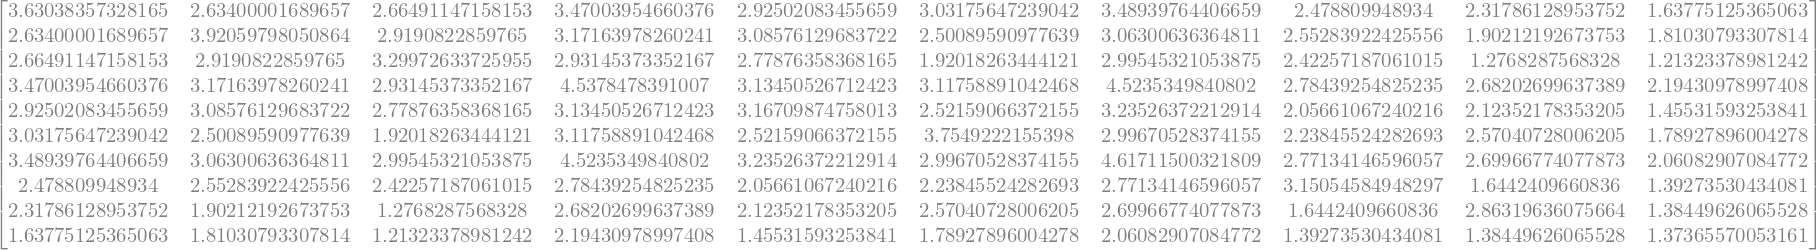


q:


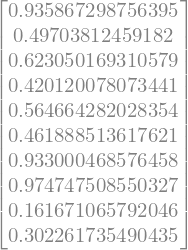


Eigenvalues of Q:


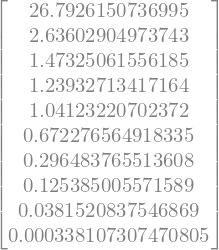

In [15]:
# Generate a random square matrix
n = 10  # Size of the matrix
matrix = np.random.rand(n, n)
# matrix = matrix * np.random.randint(1, 10)

Q = matrix.T @ matrix
q = np.random.rand(n, 1)

eigenvalues = np.linalg.eigvals(Q)
eigenvalues = sorted(eigenvalues, reverse=True)

sp.init_printing(use_latex=True)
dispQ = sp.Matrix(Q)
dispq = sp.Matrix(q)
dispeig = sp.Matrix(eigenvalues)
print("Q:")
display(dispQ)
print()
print("q:")
display(dispq)
print()
print("Eigenvalues of Q:")
display(dispeig)

In [16]:
# import plotly.graph_objects as go

# # Define the grid for plotting
# x_vals = np.linspace(0, 1, 100)
# y_vals = np.linspace(0, 1, 100)
# X, Y = np.meshgrid(x_vals, y_vals)

# # Compute Z values for the function f
# Z = np.zeros_like(X)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         x_vec = np.array([[X[i, j]], [Y[i, j]]])
#         Z[i, j] = f(Q, q, x_vec)

# # Create the 3D surface plot
# fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

# # Add labels and title
# fig.update_layout(
#     title="3D Plot of the Function f",
#     scene=dict(
#         xaxis_title="x1",
#         yaxis_title="x2",
#         zaxis_title="f(x)"
#     )
# )

# # Display the interactive plot
# fig.show()


## Generate constraints

In [17]:
n_partitions = np.random.randint(1, n + 1)
partitions = [[] for i in range(n_partitions)]
for i in range(n):
    partitions[np.random.randint(0, n_partitions)].append(i)
    
print(f"Partitions amount: {n_partitions}")
for i in range(n_partitions):
    print(partitions[i])

Partitions amount: 9
[]
[5]
[7]
[]
[8]
[1, 2]
[3]
[9]
[0, 4, 6]


## Starting point

x0:


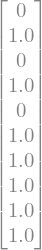

In [18]:
x0 = np.zeros((n, 1))
for part in partitions:
    if len(part) == 0:
        continue
    x0[np.random.choice(part)] = 1
print("x0:")
dispx0 = sp.Matrix(x0)
display(dispx0)

## Optimization

/tmp/ipykernel_37957/4247383727.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gap = float(grad.T @ (x - s))


Iteration 0:
gap = 8.604557554692828

Stopping criterion reached (gap ≤ 1e-06).
Elapsed time: 0.00 seconds
x_star:


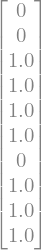

In [19]:
t0 = time.time()
x_star = frank_wolfe(Q, q, x0, partitions, max_iter=1000000, eps=1e-6, interactive=False, verbose=True)
t1 = time.time()
print(f"Elapsed time: {t1 - t0:.2f} seconds")

print("x_star:")
dispx_star = sp.Matrix(x_star)
display(dispx_star)


In [20]:
vals = []
for i in range(n_partitions):
    vals.append([])
    for j in range(len(partitions[i])):
        vals[i].append(x_star[partitions[i][j]])

for i in range(n_partitions):
    if len(vals[i]) == 0:
        continue
    print(sum(vals[i]))

[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


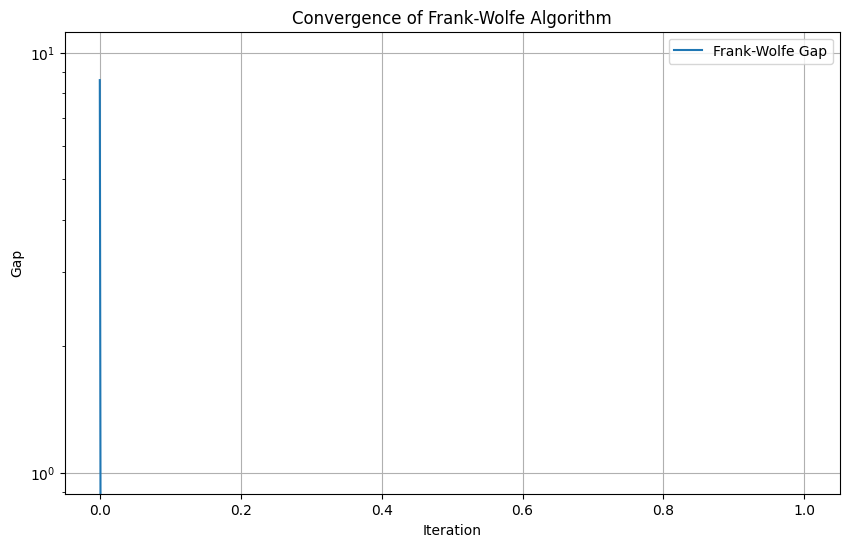

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogy(gaps, label='Frank-Wolfe Gap')
plt.xlabel('Iteration')
plt.ylabel('Gap')
plt.title('Convergence of Frank-Wolfe Algorithm')
plt.legend()
plt.grid(True)
plt.show()

## Comparison with a solver

Solver status: Singular matrix C in LSQ subproblem
Objective value: 67.71048991380474
Our value: [[60.2144]]
x (solver):


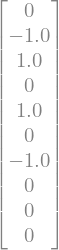

In [22]:
from scipy.optimize import minimize

# objective function f(x) = 1/2 x^T Q x + q^T x
def objective(x):
    return 0.5 * x @ (Q @ x) + q.flatten() @ x

# bounds 0 ≤ x_i ≤ 1
bounds = [(0, 1)] * n

# for each partition, the sum of the x's in that block must be 1
constraints = [
    {'type': 'eq', 'fun': lambda x, part=part: x[part].sum() - 1}
    for part in partitions
]

# initial guess (flattened)
x0_flat = x0.flatten()

res = minimize(objective,
               x0_flat,
               method='SLSQP',
               bounds=bounds,
               constraints=constraints,
               tol=1e-8,)

# reshape solution
x_solver = res.x.reshape(-1, 1)

# Set precision for displaying results
precision = 4  # Change this value to adjust precision
np.set_printoptions(precision=precision, suppress=True)

print("Solver status:", res.message)
print("Objective value:", res.fun)
print(f"Our value: {f(Q, q, x_star)}")
print("x (solver):")
diff = x_star - x_solver
display(sp.Matrix(diff))